# Bjerrum Model with the dps1200_sub data

source: https://github.com/dario-passos/DeepLearning_for_VIS-NIR_Spectra/blob/master/notebooks/Bjerrum2017_CNN/BayesOpt_CNN1.2.ipynb

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score

import keras

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
dps1200 = pd.read_csv("dps1200.csv")

In [3]:
# divide into features and lables

features = dps1200.iloc[:, 4:].values
labels = dps1200.iloc[:, 0].values

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

In [5]:
print("Form von train_data:", train_data.shape)
print("Form von train_data:", test_data.shape)

Form von train_data: (1032, 410)
Form von train_data: (258, 410)


In [6]:
## Reference hyperparameters used in Bjerrum 2017 for the standard GS dataset

## Hyperparameters for the network
DENSE = 176      # Number of neurons in the DENSE (a.k.a Fully connected) layer
DROPOUT = 0.045  # Dropout rate
C1_K  = 14       # Number of kernels/filters for conv. first layer
C1_S  = 29       # Width of the filters for first conv. layer
C2_K  = 30       # Number of kernels/filters for second conv. layer
C2_S  = 22       # Width of the filters for second conv. layer

activation='relu'  # activation function (other possible options 'elu' or 'Leaky relu')

input_dim = test_data.shape[1]

## The model
def make_model():
    """ This functions outputs the CNN model already compiled """
    model = keras.Sequential()
    #Adding a bit of GaussianNoise works as regularization
    model.add(keras.layers.GaussianNoise(0.01, input_shape=(input_dim,1)))
    #First two is number of filter + kernel size
    # model.add(keras.layers.Reshape((input_dim, 1)))
    model.add(keras.layers.Conv1D(C1_K, (C1_S), padding='same', activation=activation))
    model.add(keras.layers.Conv1D(C2_K, (C2_S), padding='same', activation=activation))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(DROPOUT))
    model.add(keras.layers.Dense(DENSE, activation=activation))
    model.add(keras.layers.Dense(1, activation='linear'))
    
    ## Compile options for the model
#     model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])
#     model.compile(loss='mse', optimizer='adam')#, metrics=['mean_absolute_error'])
    model.compile(loss=tf.keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=0.0004), metrics=['mean_absolute_error'])
#     model.compile(loss='huber_loss', optimizer='adam', metrics=['mean_squared_error'])

    return model

In [7]:
model_gs = make_model()
print(model_gs.summary())

d:\programming\python\first_steps_with_cnns\tensor\Lib\site-packages\keras\src\layers\regularization\gaussian_noise.py:29: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 410, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 410, 14)        │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 410, 30)        │         9,270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12300)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12300)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 176)            │     2,164,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           177 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,174,843 (8.30 MB)

 Trainable params: 2,174,843 (8.30 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
h = model_gs.fit(train_data, train_labels, epochs=1000, batch_size=45, validation_split=0.2) #callbacks=[early_stop]

Epoch 1/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 1734.7661 - mean_absolute_error: 1735.3302 - val_loss: 1731.5635 - val_mean_absolute_error: 1731.3124
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1709.3571 - mean_absolute_error: 1710.4369 - val_loss: 1580.1992 - val_mean_absolute_error: 1579.9558
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1455.7516 - mean_absolute_error: 1457.4393 - val_loss: 886.2930 - val_mean_absolute_error: 886.1117
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 573.7642 - mean_absolute_error: 574.7902 - val_loss: 201.8257 - val_mean_absolute_error: 202.1877
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 182.4571 - mean_absolute_error: 182.8940 - val_loss: 160.8413 - val_mean_absolute_error: 161.4012
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 164.2901 - mean_absolute_error: 164.9655 - val_loss: 162.7797 - val_mean_absolute_error: 163.8251
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━

In [9]:
print(model_gs.evaluate(test_data, test_labels, verbose=False))

[168.29806518554688, 141.11907958984375]


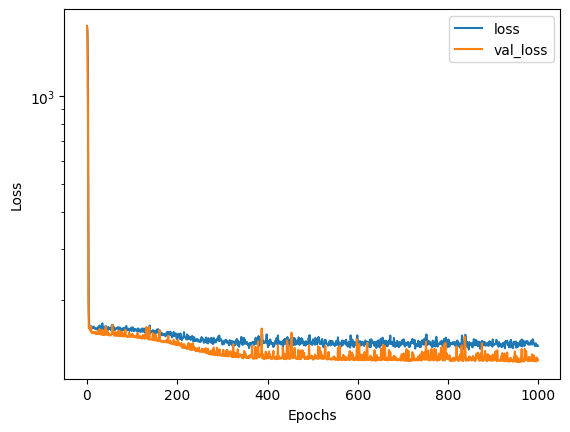

In [15]:
plt.plot(h.history['loss'], label='loss')
plt.plot(h.history['val_loss'], label='val_loss')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

In [11]:
predicted = model_gs.predict(train_data)
predicted_test = model_gs.predict(test_data)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [12]:
## Compute error metrics
def error_metrices(y_true_train, y_predicted_train, y_true_test, y_predicted_test):
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_predicted_train))
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_predicted_test))
    R2_train= r2_score(y_true_train, y_predicted_train)
    R2_test= r2_score(y_true_test, y_predicted_test)

    print('\n\n*********** Benchmark results ***********\n')
    print(f"R2    (Train/Test) = {R2_train:.3f} / {R2_test:.3f}")
    print(f"RMSE  (Train/Test) = {rmse_train:.3f} / {rmse_test:.3f}")

error_metrices(train_labels, predicted, test_labels, predicted_test)



*********** Benchmark results ***********

R2    (Train/Test) = 0.192 / 0.144
RMSE  (Train/Test) = 175.453 / 185.731


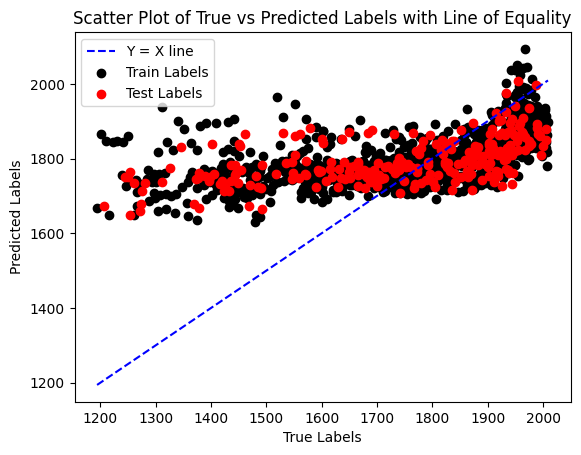

In [13]:
# Create an array of x-values ranging from the minimum to maximum of the data
x_values = np.linspace(min(labels), max(labels), 100)

# Plot the line of equality (y=x)
plt.plot(x_values, x_values, color='blue', linestyle='--', label='Y = X line')

# Scatter plot for predicted values
plt.scatter(train_labels, predicted[:, 0], c='k', label='Train Labels')
plt.scatter(test_labels, predicted_test[:, 0], c='r', label='Test Labels')

# Labels, legend, and title
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.legend()
plt.title('Scatter Plot of True vs Predicted Labels with Line of Equality')

# Show the plot
plt.show()